In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
train=pd.read_csv("covid_tweets/Corona_NLP_train.csv",encoding='latin-1')

In [18]:
test=pd.read_csv("covid_tweets/Corona_NLP_test.csv",encoding='latin-1')

In [19]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


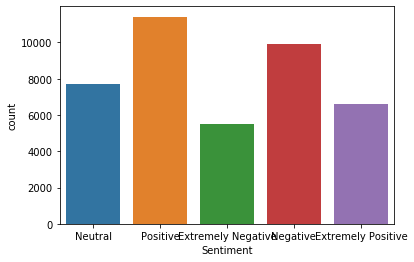

In [22]:
sns.countplot(x=train['Sentiment'])

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
tokenizer=Tokenizer(num_words=2000,oov_token='<oov>')


In [34]:
tokenizer.fit_on_texts(train['OriginalTweet'].values)

In [35]:
X_train_sequences=tokenizer.texts_to_sequences(train['OriginalTweet'].values)
X_test_sequences=tokenizer.texts_to_sequences(test['OriginalTweet'].values)

In [37]:
MAXLEN = max([len(x) for x in X_train_sequences] + [len(x) for x in X_test_sequences])

In [38]:
X_train_padded=pad_sequences(X_train_sequences,maxlen=MAXLEN)
X_test_padded=pad_sequences(X_test_sequences,maxlen=MAXLEN)

In [39]:
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()

In [40]:
y_train=train['Sentiment'].values
y_test=test['Sentiment'].values

In [42]:
y_train_enc=lbl.fit_transform(y_train)
y_test_enc=lbl.fit_transform(y_test)

In [43]:
from tensorflow.keras.utils import to_categorical
y_train_enc1=to_categorical(y_train_enc)
y_test_enc1=to_categorical(y_test_enc)

In [46]:
mapping = {
    "Extremely Positive": "Positive",
    "Extremely Negative": "Negative",
    "Positive": "Positive",
    "Neutral": "Neutral",
    "Negative": "Negative"
}

#encoding sentiment labels

y_train = train['Sentiment'].values
y_test = test['Sentiment'].values

y_train = list(map(mapping.get, y_train))
y_test = list(map(mapping.get, y_test))

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense,SpatialDropout1D
max_words=20000

In [51]:
model=Sequential()

In [53]:
model.add(Embedding(max_words,64,input_length=MAXLEN,mask_zero=True))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(20,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(y_train_enc.shape[1],activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [55]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [56]:
history=model.fit(X_train_padded,y_train_enc,epochs=10,validation_data=(X_test_padded,y_test_enc),batch_size=256)

Train on 41157 samples, validate on 3798 samples
Epoch 1/10
41157/41157 [==============================] - 34s 818us/sample - loss: 1.0015 - acc: 0.4738 - val_loss: 0.8924 - val_acc: 0.5479
Epoch 2/10
41157/41157 [==============================] - 32s 776us/sample - loss: 0.7720 - acc: 0.6811 - val_loss: 0.6673 - val_acc: 0.7335
Epoch 3/10
41157/41157 [==============================] - 34s 826us/sample - loss: 0.6286 - acc: 0.7642 - val_loss: 0.6095 - val_acc: 0.7683
Epoch 4/10
41157/41157 [==============================] - 36s 874us/sample - loss: 0.5760 - acc: 0.7900 - val_loss: 0.5847 - val_acc: 0.7817
Epoch 5/10
41157/41157 [==============================] - 36s 873us/sample - loss: 0.5536 - acc: 0.8016 - val_loss: 0.5758 - val_acc: 0.7894
Epoch 6/10
41157/41157 [==============================] - 37s 897us/sample - loss: 0.5412 - acc: 0.8068 - val_loss: 0.5772 - val_acc: 0.7894
Epoch 7/10
41157/41157 [==============================] - 36s 875us/sample - loss: 0.5314 - acc: 0.8107 -

In [59]:
model.evaluate(X_train_padded,y_train_enc)

41157/41157 [==============================] - 23s 560us/sample - loss: 0.4828 - acc: 0.8331


[0.4828311019942831, 0.8330539]

In [61]:
y_pred=model.predict(X_test_padded)
y_pred=np.argmax(y_pred,axis=1)

In [62]:
from sklearn.metrics import confusion_matrix

In [66]:
cm=confusion_matrix(y_test,y_pred)
labels = list(encoder.classes_)

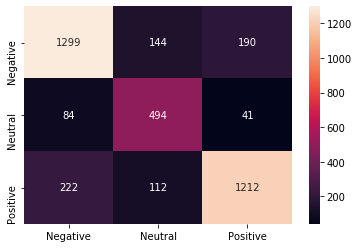

In [67]:
sns.heatmap(cm,annot=True,xticklabels=labels,yticklabels=labels,fmt='g')